In [24]:
"""Generate decadal mean monthly summary GeoTIFFs of climate variables from the NCAR 12km netcdf source data."""

import argparse
import glob
import pickle
import logging
import warnings
from pathlib import Path
import xarray as xr
import numpy as np
import rasterio as rio
from tqdm import tqdm

# local
from wrf_raster_profile import create_wrf_raster_profile
from config import (
    mo_names,
    months,
    unit_di,
    summary_di,
    variable_di,
    precision_di,
)

# A valid WRF projection can trigger this warning so I've hushed it
warnings.filterwarnings(
    "ignore",
    message="You will likely lose important projection information when converting to a PROJ string",
)

def determine_variable_group(input_dir):
    if "met" in input_dir:
        var_group = "met"  # temps, total precip
    else:
        var_group = "vic_hydro"  # all other variables
    return var_group


def get_file_paths(subgroup, input_dir):
    paths = [Path(x) for x in glob.glob(f"{input_dir}*") if subgroup in x]
    return paths


def parse_model(paths):
    model = paths[0].parent.parent.name
    return model


def parse_scenario(paths):
    scenario = paths[0].parent.name
    return scenario


def load_wrf_profile(paths=None):
    try:
        with open("wrf_profile.pickle", "rb") as handle:
            wrf_profile = pickle.load(handle)
    except:
        # or generate it
        wrf_profile = create_wrf_raster_profile(paths[0])
    return wrf_profile


def mfload_all_netcdf_data(paths):
    datacube = xr.open_mfdataset(paths, combine="nested", concat_dim=["time"])
    return datacube


def list_years_in_decade(start_year):
    return list(range(start_year, start_year + 10))


def slice_by_decade(datacube, decade_start_year):
    years = list_years_in_decade(decade_start_year)
    decade_slice = datacube.isel(time=datacube.time.dt.year.isin(years))
    return decade_slice


def compute_monthly_summaries(var_group, decade_slice, met_or_wf_or_ws, climvar):
    
    summary_func = variable_di[var_group][met_or_wf_or_ws][climvar]
    out = (
        decade_slice[climvar].sortby("time")
        .resample(time="1M")
        .reduce(summary_func)
        .groupby("time.month")
        .reduce(np.mean)  # decadal summary is always a mean
    )
    dec_mean_monthly_summary = out.compute()
    return dec_mean_monthly_summary

def compute_monthly_summaries(decade_slice, met_or_wf_or_ws, climvar):
    
    summary_func = variable_di[var_group][met_or_wf_or_ws][climvar]
    out = (
        decade_slice[climvar]
        .resample(time="1M")
        .reduce(summary_func)
        .groupby("time.month")
        .reduce(np.mean)  # decadal summary is always a mean
    )
    dec_mean_monthly_summary = out.compute()
    return dec_mean_monthly_summary

def prep_monthly_output_data(dec_mean_monthly_summary, climvar, mo):
    # we lose the orientation from xr and it flips upside down
    data = np.flipud(dec_mean_monthly_summary.sel(month=mo).data)
    # round to sensible precision levels
    data = data.round(precision_di[climvar])
    # set nodata values to -9999
    data = np.nan_to_num(data, nan=-9999.0)
    return data


def reproject_to_3338(data):
    wrf_profile = load_wrf_profile()
    out_crs = rio.crs.CRS.from_epsg(3338).to_proj4()

    (
        out_transform,
        out_width,
        out_height,
    ) = rio.warp.calculate_default_transform(
        wrf_profile["crs"].to_proj4(),
        out_crs,
        data.shape[1],
        data.shape[0],
        left=-1794000.000,
        bottom=-4046424.205,
        right=1794000.000,
        top=-1538424.205,
    )
    # init new array to reproject the data into
    dst_arr = np.empty((out_height, out_width), dtype=data.dtype)
    reprojected_data, _ = rio.warp.reproject(
        data,
        destination=dst_arr,
        src_transform=wrf_profile["transform"],
        src_crs=wrf_profile["crs"],
        src_nodata=wrf_profile["nodata"],
        dst_crs=out_crs,
        dst_transform=out_transform,
        dst_nodata=wrf_profile["nodata"],
        height=out_height,
        width=out_width,
    )
    ak_albers_profile = wrf_profile.copy()
    ak_albers_profile["crs"] = out_crs
    ak_albers_profile["transform"] = out_transform
    ak_albers_profile["height"] = out_height
    ak_albers_profile["width"] = out_width
    
    return reprojected_data, ak_albers_profile


def make_output_filename(climvar, model, scenario, mo, start_year, end_year):
    units = unit_di[climvar]
    mo_summary_func = summary_di[climvar]
    out_filename = f"{climvar.lower()}_{units}_{model}_{scenario}_{mo_names[mo]}_{mo_summary_func}_{start_year}-{end_year}_mean.tif"
    return out_filename


def write_raster_to_disk(output_dir, out_filename, ak_albers_profile, reprojected_data):
    with rio.open(
        Path(output_dir) / out_filename, "w", **ak_albers_profile
    ) as dst:
        dst.write(reprojected_data, 1)



In [30]:
def create_decadal_averages(input_dir, output_dir):

    var_group = determine_variable_group(input_dir)
    for subgroup in variable_di[var_group].keys():
        paths = get_file_paths(subgroup, input_dir)
        model = parse_model(paths)
        scenario = parse_scenario(paths)
        datacube = mfload_all_netcdf_data(paths)

        for decade_start in tqdm(range(1950, 2100, 10), desc=f"Processing decades for {model} {scenario} {subgroup} data..."):
            decade_slice = slice_by_decade(datacube, decade_start)
            for climvar in tqdm(variable_di[var_group][subgroup].keys(),  desc=f"Processing variables for {decade_start}s"):
                
                decadal_mean_of_monthly_summary = compute_monthly_summaries(var_group, decade_slice, subgroup, climvar)
                
                for mo in months:
                    single_month_output_data = prep_monthly_output_data(decadal_mean_of_monthly_summary, climvar, mo)
                    reprojected_data, raster_creation_profile = reproject_to_3338(single_month_output_data)
                    
                    output_filename = make_output_filename(climvar, model, scenario, mo, decade_start, decade_start + 9)
                    write_raster_to_disk(output_dir, output_filename, raster_creation_profile, reprojected_data)



In [31]:
from config import target_dirs
target_dirs[0]

'/atlas_scratch/Base_Data/AK_NCAR_12km/met/ACCESS1-3/rcp45/'

In [32]:
create_decadal_averages(target_dirs[0], "/atlas_scratch/cparr4/ncar_test/")

Processing decades for ACCESS1-3 rcp45 met data...:   0%|                  | 0/15 [00:00<?, ?it/s]
Processing variables for 1950s: 100%|███████████████████████████████| 3/3 [00:23<00:00,  7.88s/it]
Processing decades for ACCESS1-3 rcp45 met data...:   7%|▋         | 1/15 [00:23<05:31, 23.66s/it]
Processing variables for 1960s: 100%|███████████████████████████████| 3/3 [00:24<00:00,  8.03s/it]
Processing decades for ACCESS1-3 rcp45 met data...:  13%|█▎        | 2/15 [00:47<05:11, 23.93s/it]
Processing variables for 1970s: 100%|███████████████████████████████| 3/3 [00:24<00:00,  8.07s/it]
Processing decades for ACCESS1-3 rcp45 met data...:  20%|██        | 3/15 [01:12<04:48, 24.07s/it]
Processing variables for 1980s: 100%|███████████████████████████████| 3/3 [00:23<00:00,  7.72s/it]
Processing decades for ACCESS1-3 rcp45 met data...:  27%|██▋       | 4/15 [01:35<04:20, 23.72s/it]
Processing variables for 1990s: 100%|███████████████████████████████| 3/3 [00:23<00:00,  7.92s/it]
Processing

In [ ]:
# /atlas_scratch/cparr4/ncar_test/seventies

src = rio.open(Path("/atlas_scratch/cparr4/AK_NCAR_12km_decadal_means_of_monthly_summaries/") / "swe_mm_CSIRO-Mk3-6-0_rcp45_may_max_1970-1979_mean.tif")
show(src, vmin=0, vmax=1000)

In [ ]:
arr = src.read(1)
np.unique(arr)

In [10]:
np.unique(ncar_1979.SWE)

array([0.000000e+00, 1.000000e-03, 2.000000e-03, ..., 6.087858e+05,
       6.087859e+05,          nan], dtype=float32)

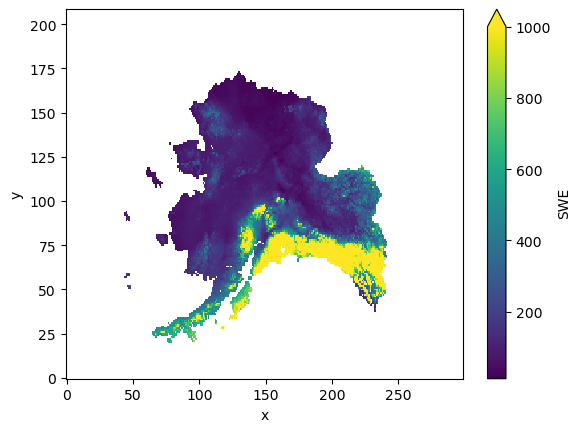

In [12]:
ncar_1979.SWE.max(axis=0).plot(vmax=1000)